# Grover's algorithm for 4 qubits (ex: finding the entry 1010)

In [10]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

In [11]:
# IBMQ.save_account('your account id')

In [12]:
provider = IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


## Building our circuit and equal superposition initialization

Let's build our circuit with 7 qubits 
* 4 qubits for input
* 1 qubit for storing the |-> state
* 2 ancilla qubits (as will be explained bellow)

And our answer will be stored in a classical register of size 4 

Further, we intialize our input in an equal superposition of all possible states

In [13]:
q = QuantumRegister(7)
c = ClassicalRegister(4)
qc = QuantumCircuit(q, c)

In [14]:
# initialize in a superposition of all possible states 
qc.x(q[4])
qc.h(q[0:5])
qc.barrier(q)

## Complete circuit diagram
source: wikipedia

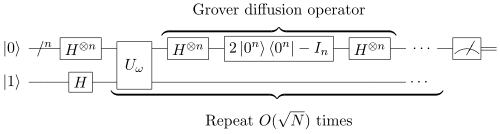

## Let's build the required oracle 

As an example I have built an oracle which check for the state |1010>

The gate named as "mct" is a Multi CNOT gate similar to a generalized CNOT discussed in class. here is it's documentation: https://qiskit.org/documentation/api/qiskit.aqua.circuits.gates.mct.html

We have to use a few ancilla qubits as which tend to follow the rule of "n-2" where "n" is the number of control qubits being used. we need 4 control qubits so we require 2 ancilla qubits. 

Another set of gates being used below are U1, U2 and U3. These are the physical gates that are implementatable on real hardware being provided by IBM Q services. Page 4 of https://arxiv.org/pdf/1807.01703.pdf paper has unitary matrix representation of these gates for your reference. 

In [15]:
qc.barrier(q)

# build oracle. ex: to find 1010 state
qc.x(q[1])
qc.x(q[3])
qc.barrier(q)
qc.mct([q[0], q[1], q[2], q[3]], q[4], q[5:7])    # control qubits, target qubit, ancilla qubits = number of control qubits - 2
qc.barrier(q)
qc.x(q[1])
qc.x(q[3])

qc.barrier(q)

## Amplitude Amplification (Diffusion Operator)

this is equivalent to flip about the mean operation geometrically. Also known as the amplitude amplification step as we are increasing the amplitudes(probability) of the entries that we flipped(gave a - phase to) in the previou step while applying our oracle. 

In [16]:
qc.barrier(q)
qc.h(q[0:4])
qc.barrier(q)
qc.x(q[0:4])
qc.barrier(q)
qc.h(q[3])
qc.barrier(q)
qc.mct([q[0], q[1], q[2]], q[3], q[5:6])   
qc.barrier(q)
qc.h(q[3])
qc.barrier(q)
qc.x(q[0:4])
qc.barrier(q)
qc.h(q[0:4])
qc.barrier(q)


In [17]:
qc.measure(q[0:4], c[0:4])

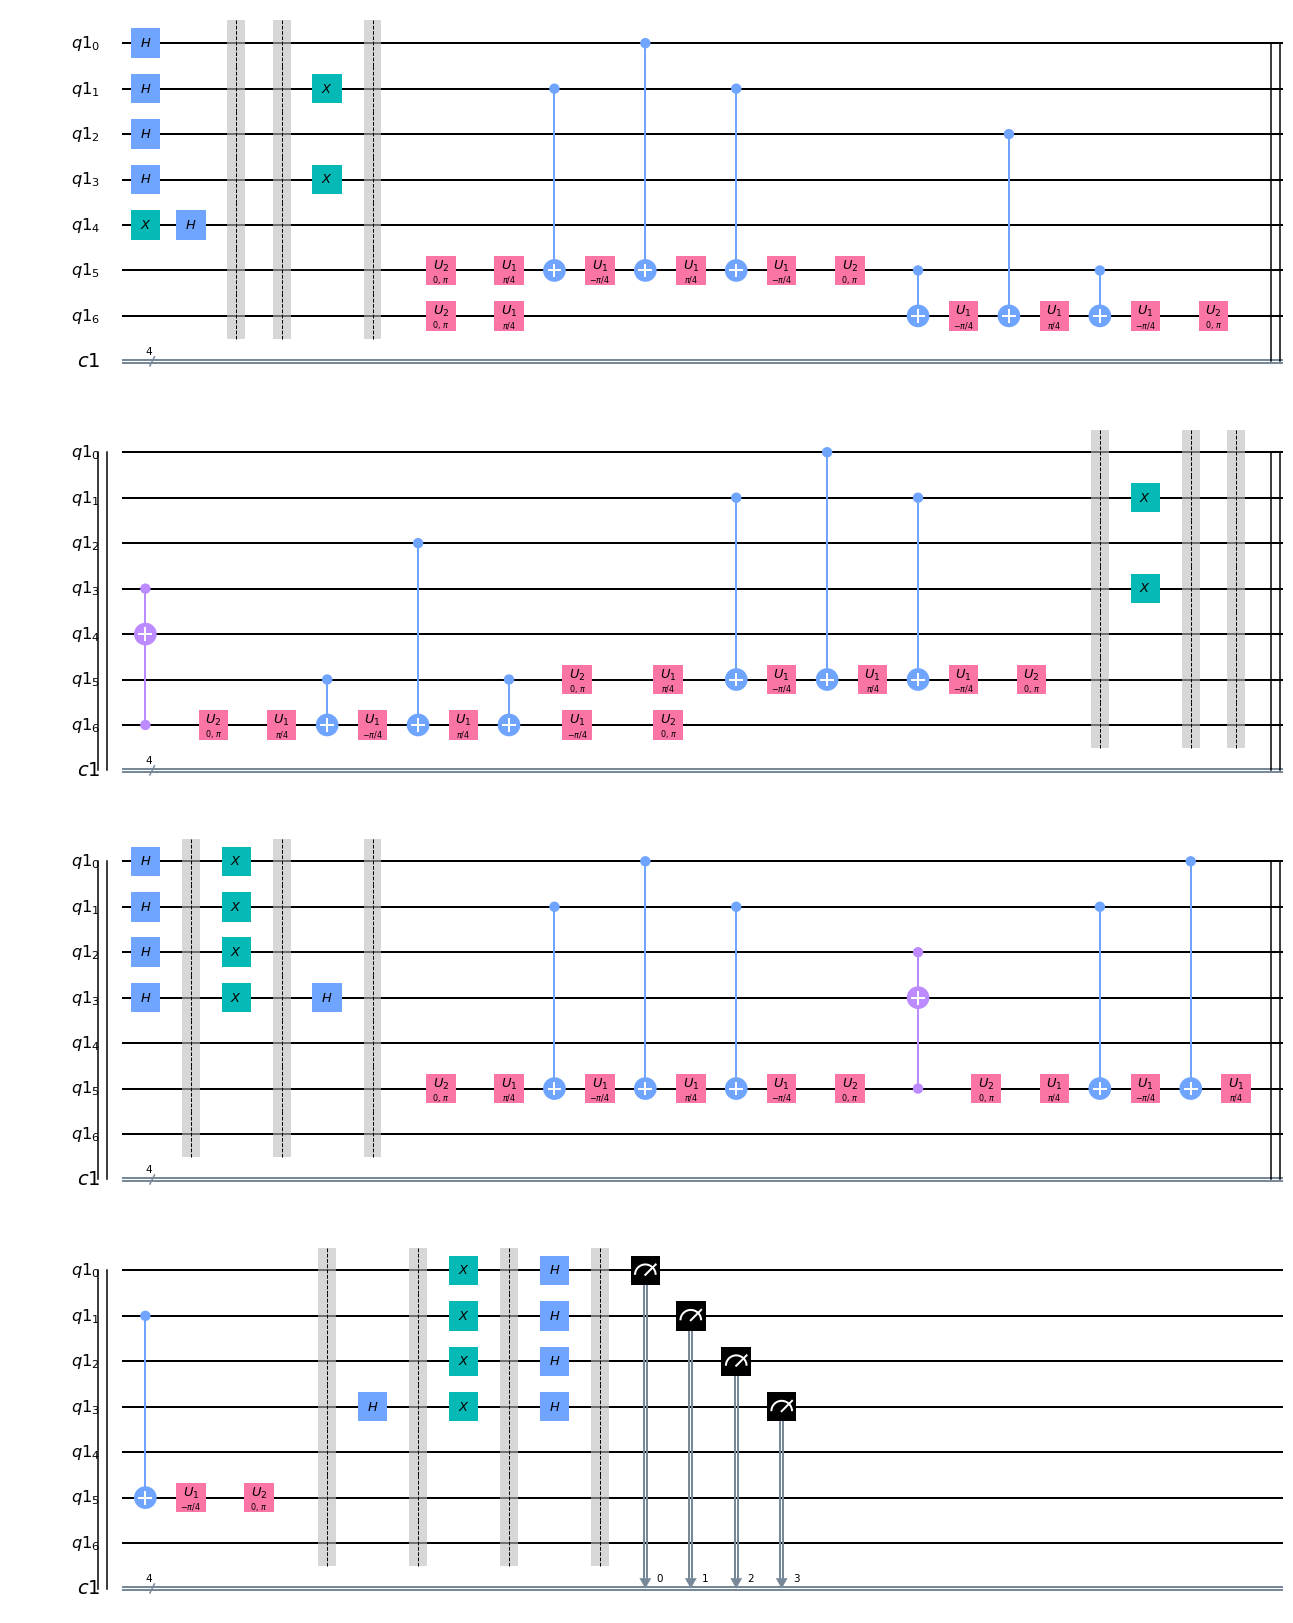

In [18]:
qc.draw(output='mpl')

# in the output drawing 

## Checking our results after running it on a simulator

Note that we have not yet used a real quantum computer as they as noisy. We could however do so by changing our provider from 'ibmq_qasm_simulator' to the hardware backend you like. 

In [19]:
# running and getting results 

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
# backend = provider.get_backend('ibmq_qasm_simulator')
# job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
result = job.result()
count = result.get_counts()
print(count)

{'1110': 35, '1111': 46, '1010': 30, '1100': 32, '1101': 39, '0110': 30, '1001': 24, '1011': 36, '0100': 37, '0011': 32, '0000': 35, '0010': 40, '0111': 35, '0001': 49, '0101': 460, '1000': 40}


In [20]:
# the code snippet below can be used to retreive your job in case your jupyter notebook loses connection with IBMQ servers before completion of the job

# backend = provider.get_backend('ibmq_qasm_simulator')
# job = backend.retrieve_job('enter your job id here. it can be found in your IBM Q Experience dashboard')
# counts = job.result().get_counts()
# print(counts)

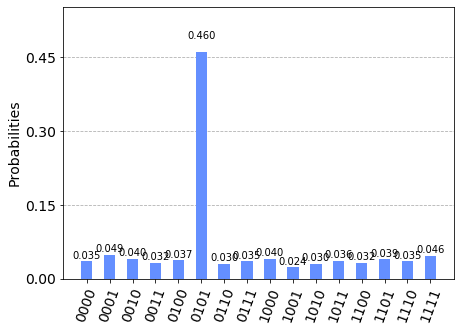

In [21]:
plot_histogram(count)

# the answer may seem inverted, i.e, 0101 is actually state 1010. that's just the notation used by qiskit.

We can see that the entry 1010 has a higher probability of appearing as compared to all the other entries. Note that we have only done the grover method once and yet got a decent answer. I encourage you to try and iterate this method multiple times to see the increase or decrease in probability. For a larger qubit number we may have to do this multiple times to get a decent probability. 